In [4]:
!pip install captum torch torchvision pandas pillow matplotlib scikit-learn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00a 0:00:01


Total images in metadata: 10015
Epoch 1/1
Batch [0/2501] Loss: 2.0674 D_Loss: 0.6854
Batch [100/2501] Loss: 0.8209 D_Loss: 0.0118
Batch [200/2501] Loss: 1.5051 D_Loss: 0.0038
Batch [300/2501] Loss: 1.6029 D_Loss: 0.0023
Batch [400/2501] Loss: 0.3762 D_Loss: 0.0011
Batch [500/2501] Loss: 1.1072 D_Loss: 0.0012
Batch [600/2501] Loss: 1.6349 D_Loss: 0.0007
Batch [700/2501] Loss: 0.7762 D_Loss: 0.0004
Batch [800/2501] Loss: 1.6988 D_Loss: 0.0007
Batch [900/2501] Loss: 1.3374 D_Loss: 0.0003
Batch [1000/2501] Loss: 0.8168 D_Loss: 0.0008
Batch [1100/2501] Loss: 1.6568 D_Loss: 0.0002
Batch [1200/2501] Loss: 0.9225 D_Loss: 0.0002
Batch [1300/2501] Loss: 0.3435 D_Loss: 0.0001
Batch [1400/2501] Loss: 1.4427 D_Loss: 0.0001
Batch [1500/2501] Loss: 0.8148 D_Loss: 0.0002
Batch [1600/2501] Loss: 1.6168 D_Loss: 0.0001
Batch [1700/2501] Loss: 1.3219 D_Loss: 0.0001
Batch [1800/2501] Loss: 2.0404 D_Loss: 0.0001
Batch [1900/2501] Loss: 0.4730 D_Loss: 0.0001
Batch [2000/2501] Loss: 0.6627 D_Loss: 0.0001
Batc

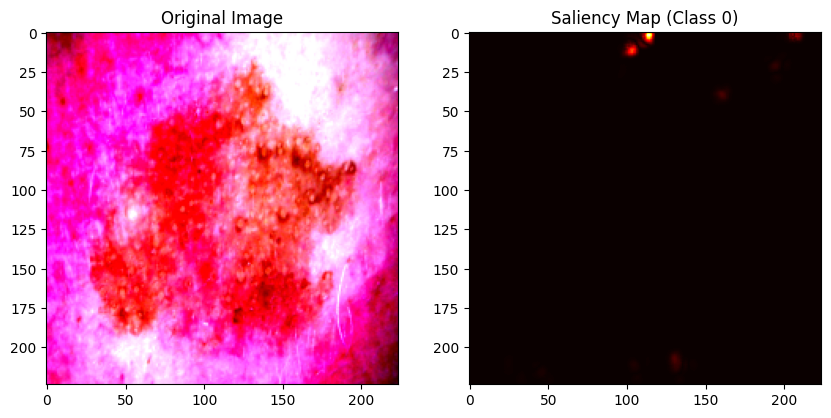

In [ ]:
import os



import pandas as pd



from PIL import Image



import torch



import torch.nn as nn



import torch.nn.functional as F



import torchvision.transforms as transforms



from torch.utils.data import Dataset, DataLoader



from sklearn.model_selection import train_test_split



import numpy as np



import matplotlib.pyplot as plt



from captum.attr import Saliency

import time
from sklearn.metrics import accuracy_score







class HAM10000Dataset(Dataset):



    def __init__(self, csv_file, img_dirs, transform=None):



        self.data = pd.read_csv(csv_file)



        self.img_dirs = img_dirs  # List of directories



        self.transform = transform







    def __len__(self):



        return len(self.data)







    def __getitem__(self, idx):



        # Look up the image name



        img_name = self.data.iloc[idx]['image_id'] + '.jpg'



        



        # Search for the image in the directories



        for img_dir in self.img_dirs:



            img_path = os.path.join(img_dir, img_name)



            if os.path.exists(img_path):



                image = Image.open(img_path).convert('RGB')



                break



        else:



            raise FileNotFoundError(f"Image {img_name} not found in specified directories.")



        



        # Get the label



        label = self.data.iloc[idx]['dx']  # Diagnosis column



        label_map = {label: idx for idx, label in enumerate(self.data['dx'].unique())}



        label = label_map[label]







        if self.transform:



            image = self.transform(image)







        return image, label







metadata_path = "../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"



metadata = pd.read_csv(metadata_path)







# Check the number of unique images in metadata



print(f"Total images in metadata: {len(metadata)}")







# Split metadata into train and test sets



train_metadata, test_metadata = train_test_split(metadata, test_size=0.001, random_state=42)







# Save split metadata for easier loading



train_metadata.to_csv("train_metadata.csv", index=False)



test_metadata.to_csv("test_metadata.csv", index=False)







# Directories containing images



image_dirs = [



    "../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",



    "../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"



]



# Attention Module



class AttentionBlock(nn.Module):



    def __init__(self, in_channels):



        super().__init__()



        self.query = nn.Conv2d(in_channels, in_channels//8, 1)



        self.key = nn.Conv2d(in_channels, in_channels//8, 1)



        self.value = nn.Conv2d(in_channels, in_channels, 1)



        



    def forward(self, x):



        batch, channels, height, width = x.size()



        q = self.query(x).view(batch, -1, height*width).permute(0,2,1)



        k = self.key(x).view(batch, -1, height*width)



        v = self.value(x).view(batch, -1, height*width)



        



        attn = torch.bmm(q, k)



        attn = F.softmax(attn, dim=2)



        out = torch.bmm(v, attn.permute(0,2,1))



        return out.view(batch, channels, height, width)







# UNet blocks



class DoubleConv(nn.Module):



    def __init__(self, in_channels, out_channels):



        super().__init__()



        self.conv = nn.Sequential(



            nn.Conv2d(in_channels, out_channels, 3, padding=1),



            nn.BatchNorm2d(out_channels),



            nn.ReLU(inplace=True),



            nn.Conv2d(out_channels, out_channels, 3, padding=1),



            nn.BatchNorm2d(out_channels),



            nn.ReLU(inplace=True)



        )



        



    def forward(self, x):



        return self.conv(x)







# UNet with Attention



class UNetWithAttention(nn.Module):



    def __init__(self, n_channels, n_classes):



        super().__init__()



        self.n_channels = n_channels



        self.n_classes = n_classes



        



        self.inc = DoubleConv(n_channels, 64)



        self.down1 = nn.Sequential(



            nn.MaxPool2d(2),



            DoubleConv(64, 128)



        )



        self.attention1 = AttentionBlock(128)



        self.down2 = nn.Sequential(



            nn.MaxPool2d(2),



            DoubleConv(128, 256)



        )



        self.attention2 = AttentionBlock(256)



        



        self.classifier = nn.Sequential(



            nn.AdaptiveAvgPool2d((1,1)),



            nn.Flatten(),



            nn.Linear(256, n_classes)



        )



        



    def forward(self, x):



        x1 = self.inc(x)



        x2 = self.down1(x1)



        x2 = self.attention1(x2)



        x3 = self.down2(x2)



        x3 = self.attention2(x3)



        return self.classifier(x3)







# Modified Discriminator to flatten output



class Discriminator(nn.Module):



    def __init__(self):



        super().__init__()



        self.main = nn.Sequential(



            nn.Conv2d(3, 64, 4, 2, 1),



            nn.LeakyReLU(0.2),



            nn.Conv2d(64, 128, 4, 2, 1),



            nn.BatchNorm2d(128),



            nn.LeakyReLU(0.2),



            nn.Conv2d(128, 256, 4, 2, 1),



            nn.BatchNorm2d(256),



            nn.LeakyReLU(0.2),



            nn.AdaptiveAvgPool2d(1),  # Global average pooling



            nn.Flatten(),



            nn.Linear(256, 1),  # Final linear layer



            nn.Sigmoid()



        )



        



    def forward(self, x):



        return self.main(x)







# Training setup



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')







transform = transforms.Compose([



    transforms.Resize((224, 224)),



    transforms.ToTensor(),



    transforms.Normalize(mean=[0.485, 0.456, 0.406], 



                       std=[0.229, 0.224, 0.225])



])







# Create datasets



train_dataset = HAM10000Dataset("train_metadata.csv", image_dirs, transform=transform)



test_dataset = HAM10000Dataset("test_metadata.csv", image_dirs, transform=transform)







train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)



test_loader = DataLoader(test_dataset, batch_size=4)







# Initialize models



model = UNetWithAttention(3, 7).to(device)



discriminator = Discriminator().to(device)







# Loss and optimizers



criterion = nn.CrossEntropyLoss()



optimizer = torch.optim.Adam(model.parameters())



d_optimizer = torch.optim.Adam(discriminator.parameters())







def calculate_accuracy(model, data_loader, device):
    model.eval()
    predictions = []
    actual = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            actual.extend(target.cpu().numpy())
    
    return accuracy_score(actual, predictions)

# Modified training loop
def train_epoch(model, discriminator, train_loader, criterion, optimizer, d_optimizer):
    model.train()
    discriminator.train()
    epoch_loss = 0
    epoch_d_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        batch_size = data.size(0)
        
        # Train discriminator
        d_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        
        d_real = discriminator(data)
        d_real_loss = F.binary_cross_entropy(d_real, real_labels)
        d_real_loss.backward()
        d_optimizer.step()
        
        # Train classifier
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_d_loss += d_real_loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f} D_Loss: {d_real_loss.item():.4f}')
    
    return epoch_loss / len(train_loader), epoch_d_loss / len(train_loader)

# Training with metrics
n_epochs = 10
train_losses = []
train_accuracies = []
training_time = []

print("Starting training...")
total_start_time = time.time()

for epoch in range(n_epochs):
    epoch_start_time = time.time()
    print(f'Epoch {epoch+1}/{n_epochs}')
    
    # Train
    train_loss, d_loss = train_epoch(model, discriminator, train_loader, criterion, optimizer, d_optimizer)
    
    # Calculate accuracy
    train_acc = calculate_accuracy(model, train_loader, device)
    
    # Record metrics
    epoch_time = time.time() - epoch_start_time
    training_time.append(epoch_time)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    print(f'Epoch {epoch+1}: Loss={train_loss:.4f}, Accuracy={train_acc:.4f}, Time={epoch_time:.2f}s')

total_time = time.time() - total_start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")

# Plot training metrics
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,3,3)
plt.plot(training_time)
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')

plt.tight_layout()
plt.show()

# Saliency map visualization



def generate_saliency_map(model, input_image, target_class=0):

    """

    Generate saliency map for a given input image and target class

    Args:

        model: trained model

        input_image: input tensor

        target_class: target class index

    """

    model.eval()

    saliency = Saliency(model)

    input_image = input_image.unsqueeze(0).requires_grad_()

    

    # Create target for specific class

    target = torch.tensor([target_class]).to(device)

    

    # Calculate attribution

    attribution = saliency.attribute(input_image, target=target)

    

    return attribution.squeeze().cpu().detach().numpy()



# Training



n_epochs = 1



for epoch in range(n_epochs):



    print(f'Epoch {epoch+1}/{n_epochs}')



    train_epoch(model, discriminator, train_loader, criterion, optimizer, d_optimizer)







# Modified visualization code

sample_data, sample_target = next(iter(test_loader))

sample_image = sample_data[0].to(device)

target_class = sample_target[0].item()  # Use actual class as target



# Generate saliency map

saliency_map = generate_saliency_map(model, sample_image, target_class)



# Visualization

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.imshow(sample_image.cpu().permute(1,2,0))

plt.title('Original Image')

plt.subplot(1,2,2)

plt.imshow(saliency_map.mean(axis=0), cmap='hot')

plt.title(f'Saliency Map (Class {target_class})')

plt.show()